In [2]:
# Book Recommendation PoC Solution (User-Based Collaborative Filtering with User Demographics)
# Language: Python
# IDE: Jupyter Notebook
# Objective: Design a book recommendation system using the provided Kaggle dataset
# Files: https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset?select=Ratings.csv


# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import pickle
import sqlite3
from datetime import datetime
import logging
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

ratings_path = './Inputfiles/Ratings.csv'
books_path = './Inputfiles/Books.csv'
users_path = './Inputfiles/Users.csv'
positive_threshold = 7 #when to ratings count as positive?
min_ratings = 3 # how many ratings to be considered for recommender?

In [3]:
#1. Data preparation
# Ratings, Books
# Load ratings dataset     
ratings = pd.read_csv(ratings_path)

books_cols_to_use = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']

books = pd.read_csv(books_path, usecols=books_cols_to_use, dtype=str)

# Year-of-Publication contains non-numeric values, so we need an additional quality step
# Keep only rows where Year-Of-Publication is a valid 4-digit integer
books = books[books['Year-Of-Publication'].str.fullmatch(r'\d{4}')]

# Convert the column to integer
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(int)

#display(books.head())

In [4]:
#1. Data preparation
# Users
# Load dataset
users = pd.read_csv(users_path)
#display(users.head())
df = pd.DataFrame(users)
#print(df.dtypes)

In [5]:
#1. Data preparation
# Users
# Preprocess users
# Split Location column into City, State, Country
users[['City', 'State', 'Country']] = users['Location'].str.split(',', n=2, expand=True)
users.drop(columns=['Location'], inplace=True)

# Strip whitespace from new columns
users[['City', 'State', 'Country']] = users[['City', 'State', 'Country']].apply(lambda x: x.str.strip())

# Create a copy to avoid SettingWithCopyWarning
users = users.copy()

# Convert Age to Int
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')
users['Age'] = users['Age'].astype('Int64')

# Filter users with Age <= 110 or NaN
users = users[users['Age'].isna() | (users['Age'] <= 110)].copy()

# Impute missing Age with median
median_age = users['Age'].median()
users['Age'] = users['Age'].fillna(median_age)

# Display result
#display(users.head())

In [6]:
# 1. Data preparation
# Ratings
# check data types
# df = pd.DataFrame(ratings)
# print(df.dtypes)

In [7]:
# 1. Data preparation
# ratings / preprocess
ratings = ratings.dropna()
ratings = ratings[ratings['Book-Rating'] != 0]  # Remove 0 ratings
ratings['User-ID'] = ratings['User-ID'].astype('category')
ratings['ISBN'] = ratings['ISBN'].astype('category')

# Preprocess books
books = books.dropna(subset=['ISBN', 'Book-Title'])

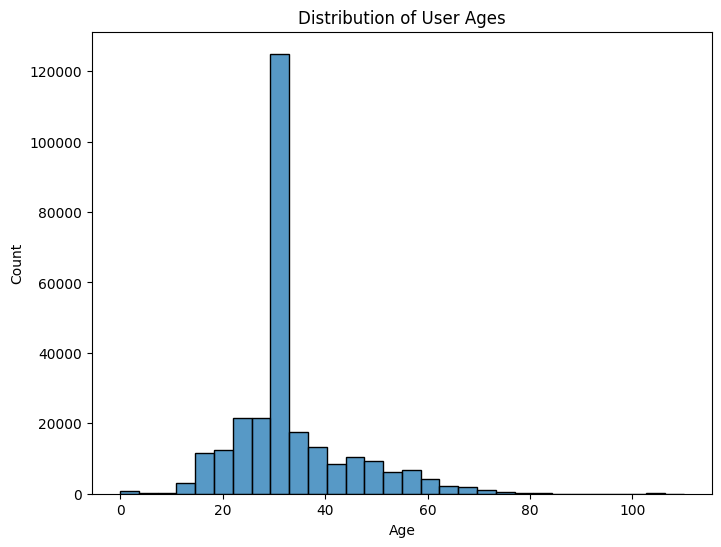

In [8]:
# 2. Data exploration
# Users
# Visualization: Age distribution
plt.figure(figsize=(8, 6))
sns.histplot(users['Age'], bins=30, kde=False)
plt.title('Distribution of User Ages')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

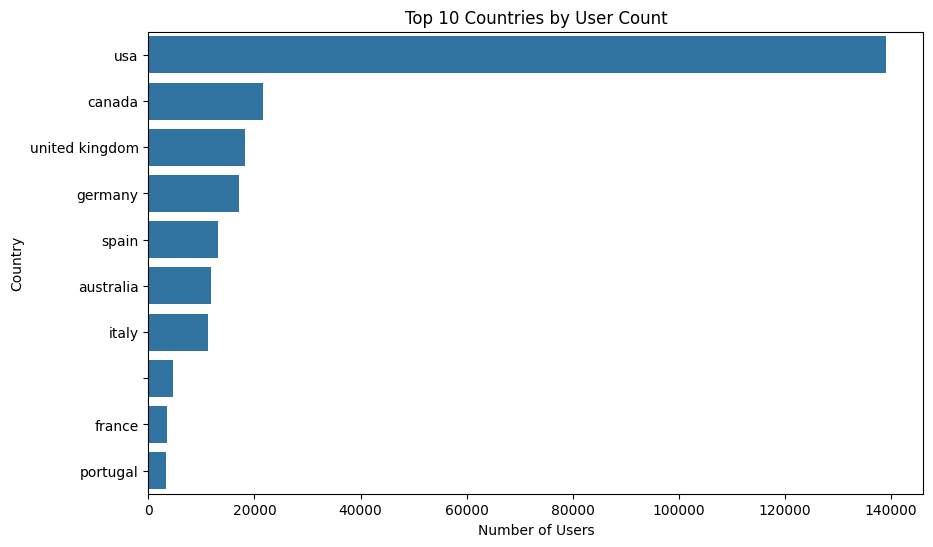

In [9]:
# 2. Data exploration
# Users
# Visualization: Top 10 countries
top_countries = users['Country'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by User Count')
plt.xlabel('Number of Users')
plt.ylabel('Country')
plt.show()

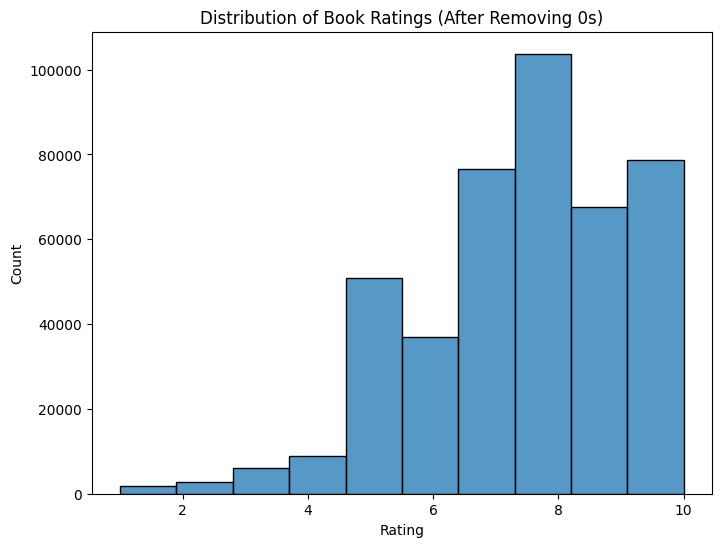

In [10]:
# 2. Data exploration
# Ratings
# Visualization: Histogram of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings['Book-Rating'], bins=10, kde=False)
plt.title('Distribution of Book Ratings (After Removing 0s)')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

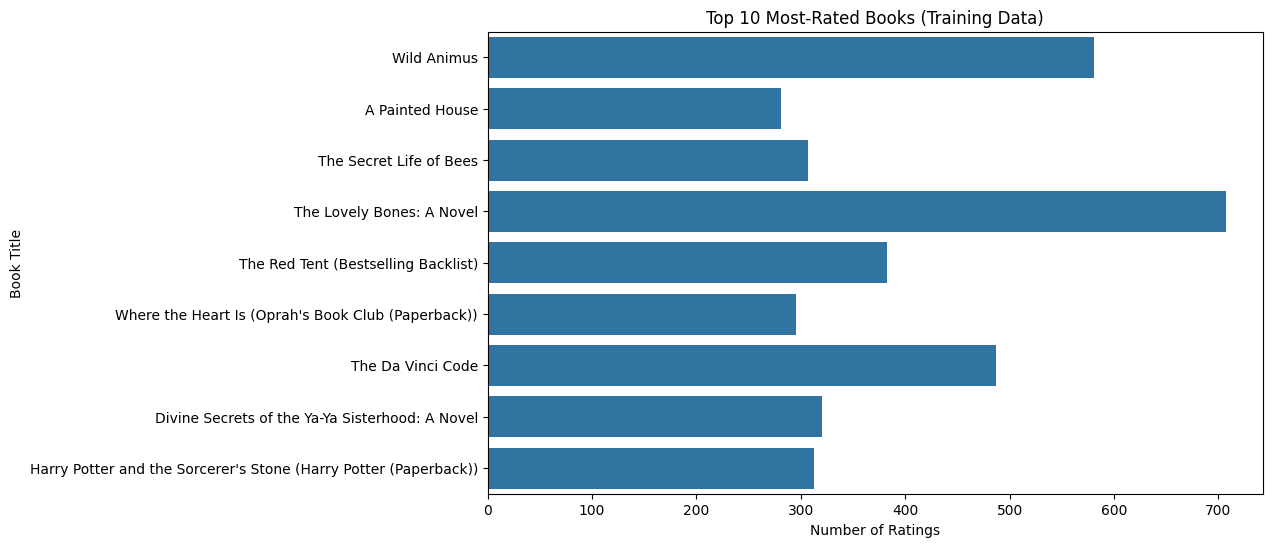

In [11]:
# 2. Data exploration
# Books
# Visualization: Top 10 most-rated books

# Compute most-rated books from training data (for visualization)
most_rated_books = ratings['ISBN'].value_counts().head(10)

# Get books with matching ISBNs and their titles
top_books_filtered = books[books['ISBN'].isin(most_rated_books.index)][['ISBN', 'Book-Title']]

# Keep only ISBNs that exist in both most_rated_books and top_books_filtered
valid_isbns = most_rated_books.index[most_rated_books.index.isin(top_books_filtered['ISBN'])]

# Ensure alignment for visualization
isbn_order = top_books_filtered[top_books_filtered['ISBN'].isin(valid_isbns)]['ISBN']
top_titles = top_books_filtered[top_books_filtered['ISBN'].isin(valid_isbns)]['Book-Title']
top_counts = most_rated_books.loc[isbn_order].values

# Create barplot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_counts, y=top_titles)
plt.title('Top 10 Most-Rated Books (Training Data)')
plt.xlabel('Number of Ratings')
plt.ylabel('Book Title')
plt.show()

# Define top_rated_books for recommendations (Step 4)
top_rated_books = ratings[ratings['Book-Rating'] >= positive_threshold].groupby('ISBN', observed=True)['Book-Rating'].mean().sort_values(ascending=False)

In [12]:
# 3. Model Building
# Split data in train/test

train_ratings, test_ratings = train_test_split(
    ratings, test_size=0.2, random_state=42
)

#create a dictionary where keys are User-ID and values are lists of ISBNs with positive ratings in the test set.
relevant_items = test_ratings[test_ratings['Book-Rating'] >= positive_threshold][['User-ID', 'ISBN']]
relevant_items = relevant_items.groupby('User-ID', observed=True)['ISBN'].apply(list).to_dict()

print(f"Train set size: {len(train_ratings)}")
print(f"Test set size: {len(test_ratings)}")

Train set size: 346936
Test set size: 86735


In [13]:
# 3. Model Building
# creating a sparse matrix / categorical data to numerical indices


# Encode User-ID and ISBN to indices
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

# Filter books with positive ratings and minimal amount of ratings from train_ratings
book_counts = train_ratings['ISBN'].value_counts()
popular_books = book_counts[book_counts >= min_ratings].index
filtered_ratings = train_ratings[
    (train_ratings['ISBN'].isin(popular_books)) &
    (train_ratings['Book-Rating'] >= positive_threshold)
]

# Encode user IDs and book IDs
user_ids = user_encoder.fit_transform(filtered_ratings['User-ID'])
book_ids = book_encoder.fit_transform(filtered_ratings['ISBN'])
ratings_values = filtered_ratings['Book-Rating'].astype(float).values

# Create COO matrix
sparse_matrix = coo_matrix(
    (ratings_values, (user_ids, book_ids)),
    shape=(len(user_encoder.classes_), len(book_encoder.classes_))
)

# Convert to CSR format for efficient operations
sparse_matrix = sparse_matrix.tocsr()

# Get index → user-ID and ISBN mapping
user_indices = pd.Series(user_encoder.inverse_transform(np.arange(len(user_encoder.classes_))))
book_indices = pd.Series(book_encoder.inverse_transform(np.arange(len(book_encoder.classes_))))

# Calculate sparsity
sparsity = 100 * (1 - sparse_matrix.count_nonzero() / (sparse_matrix.shape[0] * sparse_matrix.shape[1]))
print(f"Sparsity: {sparsity:.2f}%")

# Show example of assigned items
nonzero_user, nonzero_book = sparse_matrix.nonzero()
for i in range(min(10, len(nonzero_user))):  # Show up to 10 examples
    u_id = user_indices.iloc[nonzero_user[i]]
    b_id = book_indices.iloc[nonzero_book[i]]
    rating = sparse_matrix[nonzero_user[i], nonzero_book[i]]
    print(f"User {u_id} rated Book {b_id} with {rating}")

Sparsity: 99.98%
User 16 rated Book 0345402871 with 9.0
User 17 rated Book 0425099148 with 7.0
User 19 rated Book 0375759778 with 7.0
User 26 rated Book 0446310786 with 10.0
User 26 rated Book 0449005615 with 9.0
User 39 rated Book 0553582909 with 8.0
User 39 rated Book 0671888587 with 7.0
User 51 rated Book 0440225701 with 9.0
User 53 rated Book 0156047624 with 10.0
User 53 rated Book 0380715899 with 9.0


In [14]:
# 3.a Model Building
# Compute cosine similarity matrices between all users
user_similarity = cosine_similarity(sparse_matrix)
item_user_matrix = sparse_matrix.T
item_similarity = cosine_similarity(item_user_matrix)

In [15]:
# 3.a Model Building
# user similarity based recommendations

def recommend_books_for_user(real_user_id, sparse_matrix, user_encoder, book_encoder, user_similarity, user_indices, book_indices, books_df, top_books, top_n=10):
    # Ensure books_df index is set to ISBN
    if books_df.index.name != 'ISBN':
        books_df.set_index('ISBN', inplace=True)

    # Check if user ID is known
    if real_user_id not in user_encoder.classes_:
        # Extract top_n ISBNs from top_books (Series index)
        recommended_isbns = top_books.index[:top_n].tolist()
        # Filter ISBNs that exist in books_df
        recommended_isbns = [isbn for isbn in recommended_isbns if isbn in books_df.index]
        # Lookup titles in books_df
        recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []
        # Return DataFrame
        return pd.DataFrame({
            'ISBN': recommended_isbns,
            'Title': recommended_titles
        })
    
    # Convert real ID to matrix index
    target_idx = user_encoder.transform([real_user_id])[0]
    
    # Similarity scores for the user
    similarities = user_similarity[target_idx]
    
    # Exclude the user themself
    other_indices = np.delete(np.arange(len(similarities)), target_idx)
    sorted_similar_idxs = other_indices[np.argsort(similarities[other_indices])[::-1]]
    
    # Get books the user has already rated
    user_rated_books = sparse_matrix[target_idx].nonzero()[1]
    
    # Score accumulation
    scores = {}
    for sim_user_idx in sorted_similar_idxs:
        sim_score = similarities[sim_user_idx]
        sim_user_ratings = sparse_matrix[sim_user_idx]
        for book_idx in sim_user_ratings.nonzero()[1]:
            if book_idx in user_rated_books:
                continue
            if book_idx not in scores:
                scores[book_idx] = 0
            scores[book_idx] += sim_score * sim_user_ratings[0, book_idx]
    
    # Sort by score
    ranked_books = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Convert internal book indices to ISBNs, ensuring they exist in books_df
    recommended_isbns = [book_indices.iloc[idx] for idx, _ in ranked_books if book_indices.iloc[idx] in books_df.index]
    # Lookup titles in books_df
    recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []
    
    # If no valid recommendations, fall back to top_books
    if not recommended_isbns:
        recommended_isbns = top_books.index[:top_n].tolist()
        recommended_isbns = [isbn for isbn in recommended_isbns if isbn in books_df.index]
        recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []
    
    return pd.DataFrame({
        'ISBN': recommended_isbns,
        'Title': recommended_titles
    })

In [16]:
# 4.a Test/ Debugging
# Find out some test users with a lot of ratings
positive_matrix = sparse_matrix.multiply(sparse_matrix >= 7)
positive_counts = np.array(positive_matrix.getnnz(axis=1))
top_users = pd.DataFrame({
    'User-ID': user_encoder.inverse_transform(np.arange(len(positive_counts))),
    'PositiveRatingCount': positive_counts
}).query('PositiveRatingCount > 0').sort_values('PositiveRatingCount', ascending=False).head(10)
print(top_users)

       User-ID  PositiveRatingCount
1620     11676                 2624
14434    98391                 1171
22548   153662                  518
2345     16795                  338
34226   235105                  310
14025    95359                  302
29785   204864                  251
37564   257204                  246
8888     60244                  245
15307   104636                  242


In [17]:
# 4.a Test
# call that function

recommendations_df = recommend_books_for_user(
    real_user_id=204864,  
    sparse_matrix=sparse_matrix,
    user_encoder=user_encoder,
    book_encoder=book_encoder,
    user_similarity=user_similarity,
    user_indices=user_indices,
    book_indices=book_indices,
    books_df=books,
    top_books=top_rated_books,
    top_n=10
)

print(recommendations_df)

         ISBN                                              Title
0  0316666343                          The Lovely Bones: A Novel
1  0385504209                                  The Da Vinci Code
2  0142001740                            The Secret Life of Bees
3  0452282152                          Girl with a Pearl Earring
4  059035342X  Harry Potter and the Sorcerer's Stone (Harry P...
5  0446310786                              To Kill a Mockingbird
6  0446672211  Where the Heart Is (Oprah's Book Club (Paperba...
7  043935806X  Harry Potter and the Order of the Phoenix (Boo...
8  0345361792                            A Prayer for Owen Meany
9  0743418174                                        Good in Bed


In [18]:
# 3.b Model Building
# solution B: item similarity - could be done with association rules (e.g. apriori) or also cosine based. Decided for the latter

# Transpose the sparse matrix to get item-user matrix
item_user_matrix = sparse_matrix.T  # shape: [n_books, n_users]

# Compute item-to-item cosine similarity
item_similarity = cosine_similarity(item_user_matrix)

# Recommend books similar to a given list of ISBNs
def recommend_books_from_cart(isbn_list, book_encoder, book_indices, item_similarity, books_df, top_books, top_n=5):
    # Ensure books_df index is set to ISBN
    if books_df.index.name != 'ISBN':
        books_df.set_index('ISBN', inplace=True)

    # Helper function for fallback to top_books
    def get_top_books_fallback(top_n):
        recommended_isbns = top_books.index[:top_n].tolist()
        recommended_isbns = [isbn for isbn in recommended_isbns if isbn in books_df.index]
        recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []
        return pd.DataFrame({
            'ISBN': recommended_isbns,
            'Title': recommended_titles
        })

    # Encode ISBNs to internal indices
    try:
        item_indices = book_encoder.transform(isbn_list)
    except ValueError as e:
        print("One or more ISBNs not found:", e)
        return get_top_books_fallback(top_n)

    # Sum similarity across all cart items
    similarity_scores = np.sum(item_similarity[item_indices], axis=0)

    # Remove the original cart books from recommendations
    similarity_scores[item_indices] = 0

    # Get top-N recommended indices
    recommended_indices = np.argsort(similarity_scores)[::-1][:top_n]

    # Decode internal indices back to ISBNs
    recommended_isbns = book_indices.iloc[recommended_indices].values

    # Filter ISBNs that exist in books_df
    recommended_isbns = [isbn for isbn in recommended_isbns if isbn in books_df.index]

    # Lookup titles
    recommended_titles = books_df.loc[recommended_isbns]['Book-Title'].values if recommended_isbns else []

    # If no valid recommendations, fall back to top_books
    if not recommended_isbns:
        return get_top_books_fallback(top_n)

    return pd.DataFrame({
        'ISBN': recommended_isbns,
        'Title': recommended_titles
    })

In [20]:
# 4.b Test
# call that function
cart = ["0971880107","0446672211"]  

recommendations_df = recommend_books_from_cart(
    isbn_list=cart,
    book_encoder=book_encoder,
    book_indices=book_indices,
    item_similarity=item_similarity,
    books_df=books,
    top_books=top_rated_books,
    top_n=10
)

print(recommendations_df)

         ISBN                                              Title
0  1567186610  Celtic Myth &amp; Magick: Harness the Power of...
1  0875420222  How to Uncover Your Past Lives (Llwellyn's How...
2  0609608045  May the Angels Be With You: A Psychic Helps Yo...
3  0451184734                                    Blood Relations
4  0394552547                                      One More Time
5  0671871218                                 SEE, I TOLD YOU SO
6  0345440137                            I'm the One That I Want
7  1559120177                                 Down in the Garden
8  0451410904                                      Blushing Pink
9  0590511599  Color Me Dark: The Diary of Nellie Lee Love--T...


In [21]:
# 5. Evaluation
# Calculate metrics function
def compute_precision_recall(recommended_isbns, relevant_isbns, k):
    if not recommended_isbns or not relevant_isbns:
        return 0.0, 0.0
    recommended_set = set(recommended_isbns[:k])
    relevant_set = set(relevant_isbns)
    hits = len(recommended_set & relevant_set)
    precision = hits / k
    recall = hits / len(relevant_set)
    return precision, recall

In [24]:
print(f"Number of users in evaluation: {len(relevant_items)}")

Number of users in evaluation: 4708


In [27]:
# 5. Evaluation
# Query metrics for user-user
# Get indices of active users
user_ids = [uid for uid in relevant_items.keys() if uid in user_encoder.classes_]
user_indices_active = user_encoder.transform(user_ids)

# Compute scores for all users
scores = user_similarity[user_indices_active] @ sparse_matrix  # Shape: [n_users, n_books]
user_ratings = sparse_matrix[user_indices_active].toarray()  # Shape: [n_users, n_books]
scores[user_ratings > 0] = 0  # Exclude already rated books

# Get top-N indices for each user
k = 10
top_indices = np.argsort(scores, axis=1)[:, ::-1][:, :k]  # Shape: [n_users, k]
recommended_isbns = [book_encoder.inverse_transform(indices) for indices in top_indices]

# Create recommendation DataFrames
recommendations = []
for isbns in recommended_isbns:
    valid_isbns = [isbn for isbn in isbns if isbn in books.index]
    titles = books.loc[valid_isbns]['Book-Title'].values if valid_isbns else []
    recommendations.append(pd.DataFrame({'ISBN': valid_isbns, 'Title': titles}))

# Update evaluation loop
precisions = []
recalls = []
for user_id, rec_df in zip(user_ids, recommendations):
    recommended_isbns = rec_df['ISBN'].tolist()
    precision, recall = compute_precision_recall(recommended_isbns, relevant_items[user_id], k)
    precisions.append(precision)
    recalls.append(recall)

avg_precision = np.mean(precisions) if precisions else 0.0
avg_recall = np.mean(recalls) if recalls else 0.0
f1_scores = [2 * p * r / (p + r) if p + r > 0 else 0.0 for p, r in zip(precisions, recalls)]
avg_f1 = np.mean(f1_scores) if f1_scores else 0.0

print(f"Average Precision@{k}: {avg_precision:.4f}")
print(f"Average Recall@{k}: {avg_recall:.4f}")
print(f"Average F1@{k}: {avg_f1:.4f}")

Average Precision@10: 0.0249
Average Recall@10: 0.0368
Average F1@10: 0.0262


In [29]:
# 5. Evaluation
# Query metrics for item-item
# Get indices of active users
precisions = []
recalls = []

for user_id in user_ids:
    try:
        # Get user index
        user_idx = user_encoder.transform([user_id])[0]
        
        # Get books this user has rated
        user_rated_books = sparse_matrix[user_idx].nonzero()[1]
        
        if len(user_rated_books) == 0:
            print(f"Skipping user {user_id}: No rated books")
            continue

        # Use a subset of rated books as "cart" (limit to 3 to simulate a cart)
        cart_item_indices = user_rated_books[:min(3, len(user_rated_books))]
        cart_isbns = book_indices.iloc[cart_item_indices].values.tolist()
        
        # Filter valid ISBNs
        valid_cart_isbns = [isbn for isbn in cart_isbns if isbn in book_encoder.classes_]
        if not valid_cart_isbns:
            print(f"Skipping user {user_id}: No valid ISBNs in cart")
            continue

        # Generate item-based recommendations
        rec_df = recommend_books_from_cart(
            isbn_list=valid_cart_isbns,
            book_encoder=book_encoder,
            book_indices=book_indices,
            item_similarity=item_similarity,
            books_df=books,
            top_books=top_rated_books,
            top_n=k
        )
        
        # Extract recommended ISBNs
        recommended_isbns = rec_df['ISBN'].tolist()
        relevant_isbns = relevant_items[user_id]

        # Compute precision and recall
        precision, recall = compute_precision_recall(recommended_isbns, relevant_isbns, k)
        precisions.append(precision)
        recalls.append(recall)

    except Exception as e:
        print(f"Error processing user {user_id}: {e}")
        continue

# Compute average metrics
avg_precision = np.mean(precisions) if precisions else 0.0
avg_recall = np.mean(recalls) if recalls else 0.0
f1_scores = [2 * p * r / (p + r) if p + r > 0 else 0.0 for p, r in zip(precisions, recalls)]
avg_f1 = np.mean(f1_scores) if f1_scores else 0.0

print(f"Item-Item Precision@{k}: {avg_precision:.4f}")
print(f"Item-Item Recall@{k}: {avg_recall:.4f}")
print(f"Item-Item F1@{k}: {avg_f1:.4f}")

Item-Item Precision@10: 0.0034
Item-Item Recall@10: 0.0069
Item-Item F1@10: 0.0043


known bugs / glitches / weaknesses:
* titles sometime have more than a unique isbn - this need to be explored and treated 
* bestsellers like king james bible don't have ratings - possible?
* Filtering books with ≥5 ratings reduces the dataset but may exclude niche books that could be relevant for some users.
* untreatet expections like empty cart
* in cold start scenarios the most rated books are returned, better would be books with >n ratings and then order by avg ratings desc
* Train / Test Split is without stratification, which can result in biased sets, e.g. when user_id is generated sequentially increasing
* Result Scores are somewhat unsatisfying. Could be improved by 